In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import requests
from datetime import datetime, timedelta

Заведем список из тикеров 12 акций-голубых фишек российского рынка:

In [176]:
tickers = ['GAZP', 'GMKN', 'LKOH',
           'MGNT', 'MTSS', 'NLMK',
           'NVTK', 'PLZL', 'ROSN',
           'SBER', 'SNGS', 'TATN']

Выгрузим с API MOEX  цены закрытия акций за последние полгода:

In [177]:
def get_data(ticker, start_date, end_date):
    url = f"https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/tqbr/securities/{ticker}.json" # выгружать котировки будем с API MOEX
    params = {
        'from': start_date,
        'till': end_date,
        'start': 0
    }
    data = []
    
    while True:
        r = requests.get(url, params=params).json()
        history = r['history']['data']
        columns = r['history']['columns']
        data.extend(history)
        if not history:
            break
        params['start'] += 100
        
    df = pd.DataFrame(data, columns=columns)[['TRADEDATE', 'CLOSE']] # оставляем только дату и цену закрытия
    return df


end_date = datetime.today().date()
start_date = end_date - timedelta(days=183)
df = []
df.append(get_data(tickers[0], start_date, end_date)[['TRADEDATE']])

for ticker in tickers:
    df_temp = get_data(ticker, start_date, end_date)[['CLOSE']]
    df_temp = df_temp.rename(columns={"CLOSE": ticker}) # заменяем имя столбца с ценами на имя тикера
    df.append(df_temp)

# Объединяем все в один датафрейм
prices = pd.concat(df, axis=1)
prices.to_csv("blue_chips_halfyear.csv")

Найдем акции, которые прошли через сплит за эти полгода, для этого посмотрим у каких акций произошел резкий скачок:

In [178]:
prices = prices.ffill() # заполняем пропуски, перенося значения вниз
changes = prices[tickers].pct_change(fill_method=None)
splits = changes[abs(changes) > 0.5].dropna(how='all')
print(splits)

    GAZP  GMKN  LKOH  MGNT  MTSS  NLMK  NVTK      PLZL  ROSN  SBER  SNGS  TATN
90   NaN   NaN   NaN   NaN   NaN   NaN   NaN -0.901793   NaN   NaN   NaN   NaN


Видим, что через сплит прошли только акции компании Полюс (PLZL), также видим, что сплит был совершен в соотношении 1:10

In [179]:
split_moment = splits.index[0]
prices.loc[prices.index[:split_moment], 'PLZL']/=10

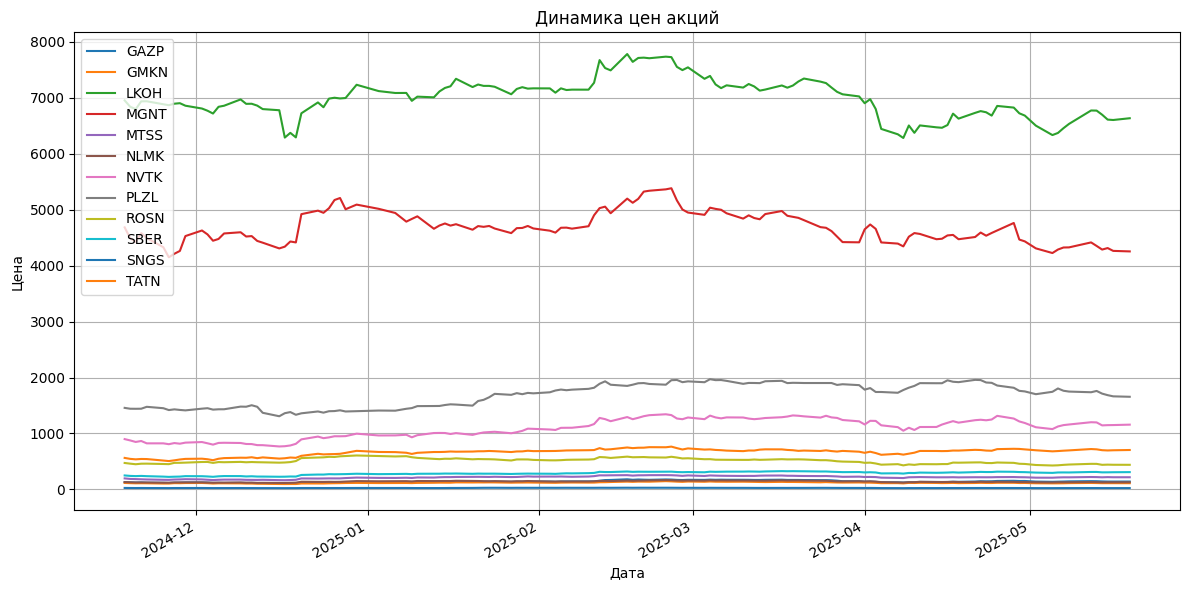

In [180]:
fig = plt.figure(figsize=(12, 6))
dates = pd.to_datetime(prices['TRADEDATE'])
prices.index = pd.to_datetime(dates)
prices.plot(ax=plt.gca())
plt.title("Динамика цен акций")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

Сгенерируем несколько случайных портфелей на наших активах и посмотрим на их ожидаемую доходность и ожидаемую волатильность:

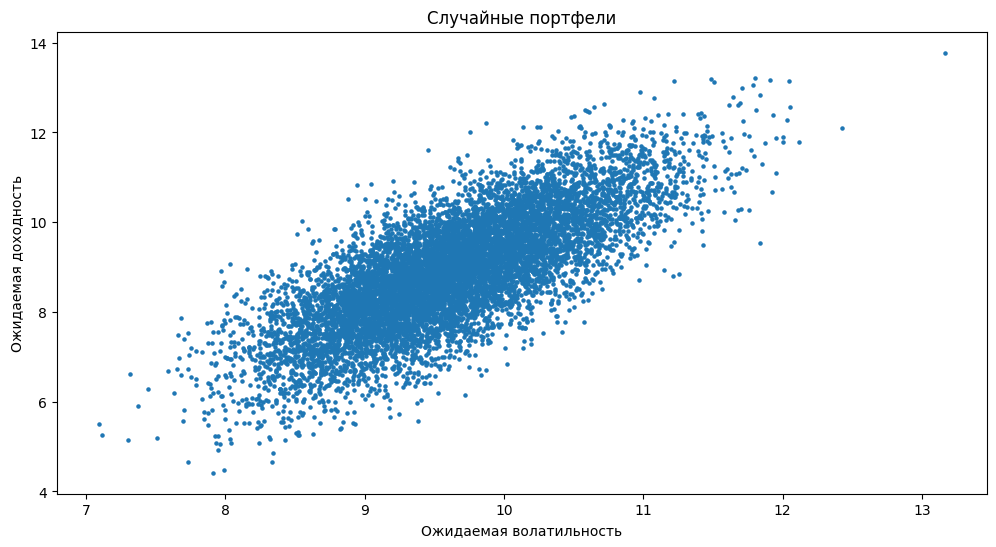

In [181]:
prices = prices.reset_index(drop=True)
n_prices = prices[tickers]/prices.iloc[0, 1:]

returns_mean = (n_prices - 1).mean()
returns_cov = n_prices.cov()

ret_list = []
vol_list = []


for i in range(10000):
    weights = np.random.random(len(tickers))
    n_weights = weights/np.sum(weights)
    rp_return = returns_mean @ n_weights.T
    rp_var = n_weights @ returns_cov @ n_weights.T
    ret_list.append(rp_return)
    vol_list.append(np.sqrt(rp_var))
random_ports = pd.DataFrame({'Return': ret_list, 'Volatility': vol_list}) * 100


fig = plt.figure(figsize=(12, 6))
random_ports.plot(x='Volatility', y='Return', kind='scatter', s=5, ax=plt.gca())
plt.xlabel('Ожидаемая волатильность')
plt.ylabel('Ожидаемая доходность')
plt.title('Случайные портфели')
plt.show()

Теперь при заданной доходности найдем портфель с наименьшей волатильностью, для этого решим задачу оптимизации: сумма весов равна 1, при этом все веса от 0 до 1, ожидаемая доходность фиксирована. 

In [182]:
def volatility_portfolio(weights):
    return np.sqrt(weights @ returns_cov @ weights.T)


def mean_portfolio(weights):
    return weights @ returns_mean


bounds = tuple((0, 1) for _ in range(len(tickers)))
init_weights = np.ones(len(tickers))/len(tickers)
target_p = 0.12
constraints = ({'type': 'eq', 'fun': lambda x: mean_portfolio(x) - target_p}, # ожидаемая доходность должна быть равна target_p
               {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # сумма весов должна быть равна 1
mvp = sco.minimize(volatility_portfolio, init_weights, bounds=bounds, constraints=constraints)
mvp_weights = pd.DataFrame([mvp.x], columns=tickers)
mvp_weights.round(6)

,GAZP,GMKN,LKOH,MGNT,MTSS,NLMK,NVTK,PLZL,ROSN,SBER,SNGS,TATN
0,0.0,0.0,0.151447,0.0,0.0,0.0,0.0,0.12768,0.303595,0.0,0.0,0.417279


Проследим как такой портфель показал себя по сравнению с портфелем, в котором активы были распределены равномерно.

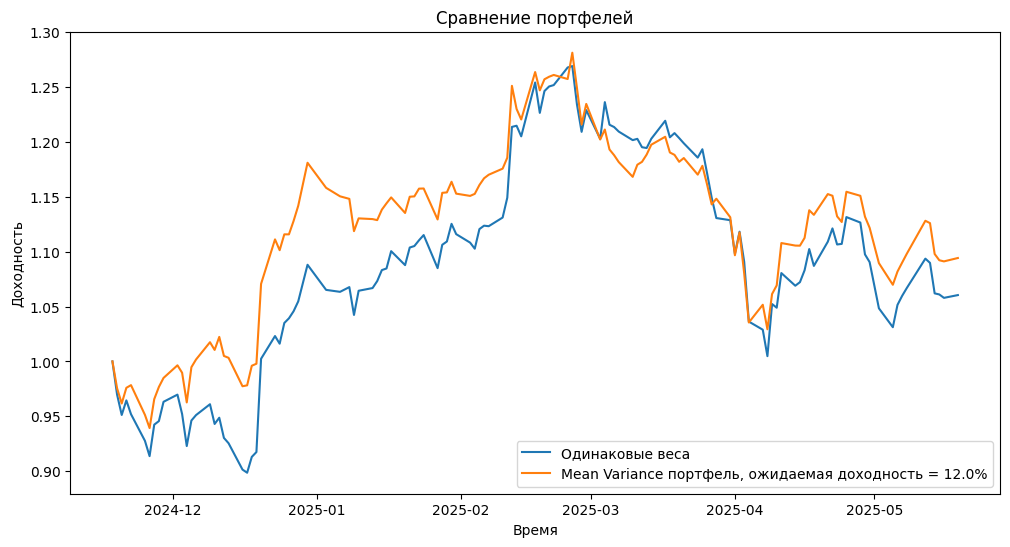

In [184]:
mvp_prices = n_prices @ mvp_weights.iloc[0, :]
equal_weights = np.ones(len(tickers))/len(tickers)
equal_weight_prices = n_prices @ equal_weights


fig = plt.figure(figsize=(12, 6))
plt.plot(dates, equal_weight_prices, label = 'Одинаковые веса')
plt.plot(dates, mvp_prices, label = f'Mean Variance портфель, ожидаемая доходность = {target_p*100}%')
plt.xlabel('Время')
plt.ylabel('Доходность')
plt.legend()
plt.title('Сравнение портфелей')
plt.show()